# Solar Power Generation Project

## Introduction
The data for this project can be found on [Kaggle](https://www.kaggle.com/anikannal/solar-power-generation-data). My main goal was to use the Scikit-Learn library to answer the three main questions.

1. Can we predict the power generation for next couple of days? - this allows for better grid management
2. Can we identify the need for panel cleaning/maintenance?
3. Can we identify faulty or suboptimally performing equipment?

I've included some of the models I tried which were not the best models to show my thought process during this project.

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler, scale
from sklearn.cluster import KMeans, AffinityPropagation
from datetime import time

## Predicting Power Generation
The following code includes two classes I created to prepare the data before training a model. There were two .csv files provided for each plant. The first class `PrepGenerationData` prepares data on 22 inverters measuring production of the solar panels. `PrepWeatherData` prepares data from 1 inverter measuring the temperature and irradiation of each plant. More detailed comments on what each class does can be found within the code.

In [16]:
class PrepGenerationData:
    def __init__(self,filename):
        self.filename = filename
    
    def prep_data(self):
        #PLANT_ID only contains one value since the .csv is unique to the plant. TOTAL_YIELD is a cumulative sum over the existence of each
        #inverter. However, we only have about 1 month's worth of data for each inverter, so DAILY_YIELD is more useful. That's why I chose
        #to drop each of these values.
        df = pd.read_csv(self.filename).drop(columns = ['PLANT_ID', 'TOTAL_YIELD'], axis = 1)
        #Convert DATE_TIME to a datetime object and make it the index. Sort by inverter and then date.
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], dayfirst = True)
        df = df.sort_values(['SOURCE_KEY', 'DATE_TIME']).set_index('DATE_TIME')
        #This is a special command included for Plant 2. Its DAILY_YIELD column was corrupted and was carrying data from one day several
        #hours into the next day. It should be reset at midnight.
        df.iloc[df.index.indexer_between_time(time(0), time(4)), -1] = 0
        
        #Convert SOURCE_KEY from object to integer we can use. This is mostly for readability, but I do reference a couple of inverters
        #later on.
        new_sourcekey_num = list(np.arange(0,22))
        old_source_key = list(df['SOURCE_KEY'].unique())
        for n in range(len(old_source_key)):
            df = df.replace(old_source_key[n],new_sourcekey_num[n])
        del(old_source_key,new_sourcekey_num,n)
        
        #Create a list of dataframes containing summary statistics for each production column. DAILY_YIELD is a cumulative sum, so its daily
        #summary is its max.
        filter_df_inverter = []
        for inverter in df['SOURCE_KEY'].unique():
            df_inverter = df[df['SOURCE_KEY'] == inverter]
            ac = df_inverter['AC_POWER'].resample('1D').sum()
            dc = df_inverter['DC_POWER'].resample('1D').sum()
            daily_yield = df_inverter['DAILY_YIELD'].resample('1D').max()
            
            d = {'SOURCE_KEY':df_inverter['SOURCE_KEY'],
                'AC_POWER': ac,
                 'DC_POWER': dc,
                 'DAILY_YIELD': daily_yield}
            new_df = pd.DataFrame(data = d,
                                  index = ac.index)
            filter_df_inverter.append(new_df)
        
        #Create a new dataframe with the summary statistics for every inverter.
        eod = filter_df_inverter[0].reset_index()
        for inverter in range(1,df['SOURCE_KEY'].nunique()):
            df_inverter = filter_df_inverter[inverter].reset_index()
            eod = pd.concat([eod, df_inverter])
        eod = eod.set_index('DATE_TIME').fillna(method = 'bfill')
        del (inverter, df_inverter, filter_df_inverter, ac, dc)
        
        return(eod)

In [17]:
class PrepWeatherData:
    def __init__(self,filename):
        self.filename = filename
    
    def prep_data(self):
        #Import and pred DATE_TIME similarly to the generation data.
        df_weather = pd.read_csv(self.filename).drop(columns = 'PLANT_ID', axis = 1)
        df_weather['DATE_TIME'] = pd.to_datetime(df_weather['DATE_TIME'], dayfirst = True)
        #There are a lot of missing timestamps. I included those timestamps and filled in the NaN values with DataFrame.interpolate(), which
        #attempts to predict the rate of change between two non-NaN values and fills in the missing data accordingly.
        df_weather = df_weather.set_index('DATE_TIME').asfreq('15T')
        df_weather = df_weather.interpolate()
        
        #There's only one inverter in the weather data. I keep it because I'll join each dataset on their SOURCE_KEY column later when 
        #training. Below, I again compute summary statistics for the inverter and create a new dataframe containing them.
        ambient = df_weather['AMBIENT_TEMPERATURE'].resample('1D').mean()
        module = df_weather['MODULE_TEMPERATURE'].resample('1D').mean()
        irradiation = df_weather['IRRADIATION'].resample('1D').mean()
        
        d = {'AMBIENT_TEMPERATURE': ambient,
             'MODULE_TEMPERATURE': module,
             'IRRADIATION': irradiation}
        new_df = pd.DataFrame(data = d, index = ambient.index)
        return(new_df)

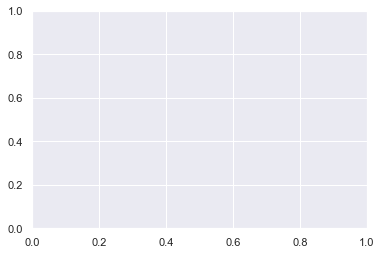

In [18]:
#Import prepared generation data for Plant 1
eod_df = PrepGenerationData('data/Plant_1_Generation_Data.csv').prep_data()

fig, ax = plt.subplots()
sns.set_theme()

Below is a pairplot visualizing the correlations among the three measures of power production.

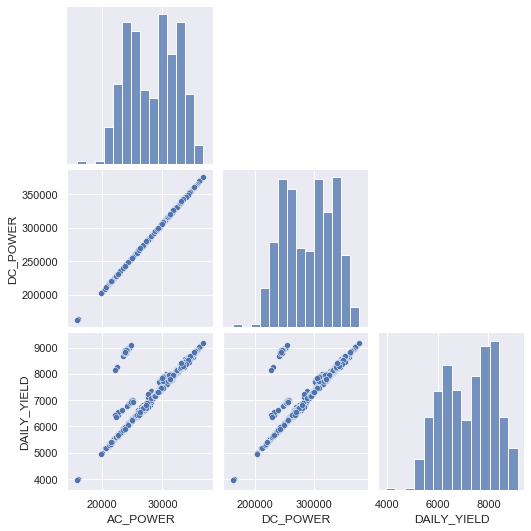

In [19]:
ax = sns.pairplot(data = eod_df.drop(columns = 'SOURCE_KEY'), corner = True)
plt.savefig('figures/Correlation_Matrix.png')
plt.close(fig)

In the chart above, I don't think it should be surprising that DC power generation and AC power generation are directly correlated, practically at a rate of 1. These production values happen in conjunction as each solar panel has access to the sun. It should be the case that each power generation has a direct correlation with Daily Yield as well. While that correlation is present, we can also see some outlier points, which have the correct correlation, but are higher in power. To this point in the project, they ony appear to be very productive days and not the cause of any issues with the model.

### Ridge Regression
Below is the code for the first training model. I used Ridge Regression with built in cross-validation. I started training without including the weather data as I wanted an idea of just how much information we could get from production data alone.

In [20]:
#Run Ridge Regression on each inverter's data.
ridge_score = []
reg = linear_model.RidgeCV(normalize = True)
for inverter in eod_df['SOURCE_KEY'].unique():
    eod_df_test = eod_df[eod_df['SOURCE_KEY'] == inverter]
    X = eod_df_test[['AC_POWER', 'DC_POWER']]
    y = eod_df_test['DAILY_YIELD']
    
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                      test_size = 0.1, shuffle = False,
                                                      random_state = 12)
    reg.fit(X_train, y_train)
    ridge_score.append(reg.score(X_val, y_val))
    
ridge_score = pd.DataFrame(np.asarray(ridge_score), index = eod_df['SOURCE_KEY'].unique(), columns = ['Ridge Score'])
print(ridge_score)

      Ridge Score
0.0      0.836310
1.0      0.717446
2.0      0.805486
3.0      0.670285
4.0      0.695995
5.0      0.673413
6.0      0.785326
7.0      0.715876
8.0      0.769437
9.0      0.741669
10.0     0.728251
11.0     0.829135
12.0     0.746584
13.0     0.747472
14.0     0.689508
15.0     0.747064
16.0     0.705216
17.0     0.704173
18.0     0.693087
19.0     0.712827
20.0     0.765304
21.0     0.757843


So, ridge regression wasn't great. To fix this, I attempted a regression model with a different regularization metrix, Lasso regression. Again, cross-validation is built into this model.

### Lasso Regression

In [21]:
#Run Lasso Regression on the same data
lasso_score = []
reg = linear_model.LassoCV(normalize = True, max_iter = 10000,
                               random_state = 12)
for inverter in eod_df['SOURCE_KEY'].unique():
    eod_df_test = eod_df[eod_df['SOURCE_KEY'] == inverter]
    X = eod_df_test[['AC_POWER', 'DC_POWER']]
    y = eod_df_test['DAILY_YIELD']
    
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                      test_size = 0.1, shuffle = False,
                                                      random_state = 12)
    reg.fit(X_train, y_train)
    lasso_score.append(reg.score(X_val, y_val))
    
lasso_score = pd.DataFrame(np.asarray(lasso_score), index = eod_df['SOURCE_KEY'].unique(), columns = ['Lasso Score'])
print(lasso_score)

      Lasso Score
0.0      0.829929
1.0      0.697375
2.0      0.780783
3.0      0.655235
4.0      0.680934
5.0      0.663972
6.0      0.762141
7.0      0.703871
8.0      0.764485
9.0      0.731041
10.0     0.702012
11.0     0.831584
12.0     0.731213
13.0     0.737416
14.0     0.665430
15.0     0.719312
16.0     0.690095
17.0     0.673928
18.0     0.683773
19.0     0.712956
20.0     0.755932
21.0     0.723437


It seems that Lasso regression is comparable to Ridge regression. At this point, I'm satisfied that the regularization metric isn't going to have a significant effect on the training. Next is to see how much we can improve by including the weather data.

I only have one inverter's worth of weather data. However, I need to train my model on each of the production inverters. Since all of the production inverters exist within the same plant, the weather data should apply uniformly to each one. So, as I filtered the dataframe by each inverter in the code below, I chose that moment to join the weather data.

In [22]:
#Add the data we have from the weather inverter and run Lasso Regression again
weather_df = PrepWeatherData('data/Plant_1_Weather_Sensor_Data.csv').prep_data()
lasso_with_weather_score = []

for inverter in eod_df['SOURCE_KEY'].unique():
    eod_df_test = eod_df[eod_df['SOURCE_KEY'] == inverter].join(weather_df)
    X = eod_df_test.drop(columns = ['SOURCE_KEY', 'DAILY_YIELD'])
    y = eod_df_test['DAILY_YIELD']
    
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                      test_size = 0.1, shuffle = False,
                                                      random_state = 12)
    reg.fit(X_train,y_train)
    lasso_with_weather_score.append(reg.score(X_val, y_val))

lasso_with_weather_score = pd.DataFrame(np.asarray(lasso_with_weather_score), 
                                        index = eod_df['SOURCE_KEY'].unique(), columns = ['Lasso Score with Weather'])
print(lasso_with_weather_score)
del(X_val, y_val)

      Lasso Score with Weather
0.0                   0.173133
1.0                   0.968180
2.0                   0.950376
3.0                   0.974418
4.0                   0.981032
5.0                   0.972995
6.0                   0.931037
7.0                   0.983387
8.0                   0.975417
9.0                   0.970891
10.0                  0.968837
11.0                  0.337497
12.0                  0.986842
13.0                  0.975568
14.0                  0.987801
15.0                  0.985542
16.0                  0.975967
17.0                  0.979232
18.0                  0.976995
19.0                  0.959754
20.0                  0.915910
21.0                  0.983284


So, determining what we could say with just the production data earlier was nice, but rather useless. The weather data is essential to predicting power production, and we can see the model is consistently >95% accurate for most of the inverters. I'll point out here that Ridge regression produced similar results to the scores above. However, production from inverters 0 and 11 is actually quite badly predicted by our model. Given that the model works well for all the other sensors, my first guess is that something makes these two inverters unique from the rest. 

Below, I add a new column to the dataframe marking inverters 0 and 11 with a 1, and all other inverters with a 0. I then plot their average Daily Yields and compare the two.

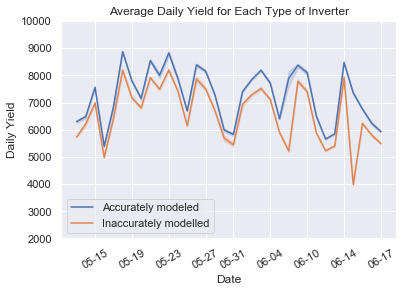

In [23]:
#Create a chart to display what's wrong with inverters 0 and 11
eod_df['mark'] = np.zeros(shape = len(eod_df))
eod_df['mark'] = eod_df['mark'].mask(eod_df['SOURCE_KEY'] == 0, 1).mask(eod_df['SOURCE_KEY'] == 11, 1)    

ax = sns.lineplot(x = eod_df.index.date, y = 'DAILY_YIELD', data = eod_df, hue = eod_df.mark)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Yield')
ax.set_title('Average Daily Yield for Each Type of Inverter')
ax.set_xticklabels(labels = ['05-15','05-19','05-23','05-27','05-31','06-04','06-10','06-14','06-17'], rotation = 30)
ax.set_ylim(bottom = 2000, top = 10000)
ax.legend(labels = ['Accurately modeled', 'Inaccurately modelled'], loc = 'lower left')
plt.savefig('figures/Comparing_Underperforming_Inverters.png')
plt.close(fig)

It's clear that inverters 0 and 11 are consistently lower in production than the other inverters. Again, this graph shows the averages of each group. All 22 inverters on one graph is hard to decipher. I can continue trying to improve the model; but since identifying subperforming equipment was one of the goals of this project, I'm going to leave it alone for now. Instead, I'm going to test the model on the data from Plant 2.

### What's Wrong with Plant 2?

In [24]:
#Let's test it out on Plant 2
eod_df_2 = PrepGenerationData('data/Plant_2_Generation_Data.csv').prep_data()
weather_df_2 = PrepWeatherData('data/Plant_2_Weather_Sensor_Data.csv').prep_data()
df_2_score = []
for inverter in eod_df_2['SOURCE_KEY'].unique():
    eod_df_test = eod_df_2[eod_df_2['SOURCE_KEY'] == inverter].join(weather_df_2)
    X = scale(eod_df_test.drop(columns = ['SOURCE_KEY', 'DAILY_YIELD']))
    y = scale(eod_df_test['DAILY_YIELD'])
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size = 0.1, shuffle = False,
                                                        random_state = 12)
    reg.fit(X_train, y_train)
    df_2_score.append(reg.score(X_test,y_test))
df_2_score = pd.DataFrame(np.asarray(df_2_score), index = eod_df_2['SOURCE_KEY'].unique(), columns = ['Lasso Score'])
print(df_2_score)
del(X, X_train, X_test, eod_df_test, inverter, y, y_train, y_test)

      Lasso Score
0.0     -0.295439
1.0      0.798160
2.0      0.998997
3.0     -0.655867
4.0      0.796661
5.0      0.602130
6.0      0.729950
7.0     -1.981191
8.0      0.546735
9.0     -0.499781
10.0    -0.761839
11.0    -0.292439
12.0     0.998221
13.0     0.681450
14.0     0.188211
15.0    -0.711111
16.0     0.999605
17.0     0.491695
18.0    -0.270824
19.0     0.759453
20.0     0.683818
21.0     0.763709


Bad. Like, really bad. There are a few inverters that are acuratly predicted, but the results are all over the place. The source of this data states the plants are close together in location. It seems reasonable that they should have similar data, but the scores show that is clearly not the case. Some data analysis I did but haven't shown yet goes a long way towards explaining why.

Below are two graphs showing how the Daily Yield of each inverter changes over the time of this data collection. Each graph represents a different plant. This time, I did plot each inverter individually; but, it's not helpful to focus on that, Instead, I'm trying to show how each plant has significantly different performances within itself.

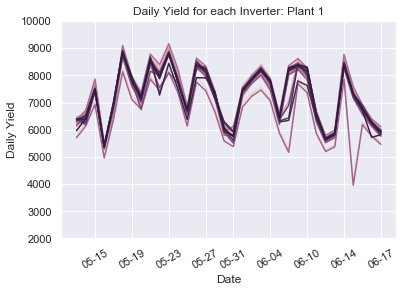

In [25]:
ax = sns.lineplot(x = eod_df.index, y = 'DAILY_YIELD',data = eod_df, hue = 'SOURCE_KEY', legend = False)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Yield')
ax.set_title('Daily Yield for each Inverter: Plant 1')
ax.set_xticklabels(labels = ['05-15','05-19','05-23','05-27','05-31','06-04','06-10','06-14','06-17'], rotation = 30)
ax.set_ylim(bottom = 2000, top = 10000)
plt.savefig('figures/Daily_Yield_for_Inverters_Plant_1.png')
plt.close(fig)

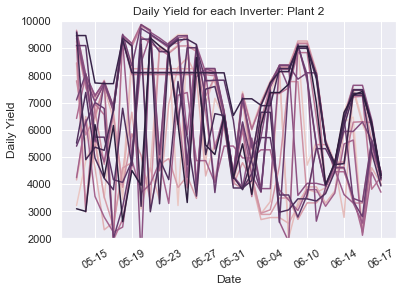

In [26]:
ax = sns.lineplot(x = eod_df_2.index, y = 'DAILY_YIELD', data = eod_df_2, hue = eod_df.SOURCE_KEY, legend = False)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Yield')
ax.set_title('Daily Yield for each Inverter: Plant 2')
ax.set_xticklabels(labels = ['05-15','05-19','05-23','05-27','05-31','06-04','06-10','06-14','06-17'], rotation = 30)
ax.set_ylim(bottom = 2000, top = 10000)
plt.savefig('figures/Daily_Yield_for_Inverters_Plant_2.png')
plt.close(fig)

Clearly, the model worked for Plant 1 because each production inverter in the plant responds similarly to the weather on a given day. Meanwhile, the inverters in Plant 2 have wildly different production rates. At this point, I realized the data on Plant 2 was included in this project to help answer the other two goals: to find broken and suboptimally performing equipment. The rest of this project will look at that.

## Classifying Broken and Suboptimally Performing Equipment
Below are the classes I created to prepare data for classifying equipment as broken or suboptimal. I took the classes I had already created and tweaked them for the needs of this section. There is also a function `multi_plot`, for which I must give credit to [lumierebatalong](https://www.kaggle.com/lumierebatalong/solar-power-machine-learning-i). I've altered it for my project and its purpose is to visualize the Daily Yield per day for a single inverter.

In [96]:
class PrepGenerationDataforClassification:
    def __init__(self,filename):
        self.filename = filename
    
    def prep_data(self):        
        df = pd.read_csv(self.filename).drop(columns = ['PLANT_ID','TOTAL_YIELD'],axis = 1)
        
        #Normalize DC_POWER, AC_POWER, and DAILY_YIELD
        normalizer = Normalizer()
        df[['DC_POWER','AC_POWER','DAILY_YIELD']] = normalizer.fit_transform(df[['DC_POWER','AC_POWER','DAILY_YIELD']].values)
        
        #Convert datetime to correct format, create new columns for date and time
        #Set datetime as the index
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], dayfirst = True)
        df['date'] = pd.to_datetime(df['DATE_TIME'].dt.date)
        df['time'] = df['DATE_TIME'].dt.time
        df = df.sort_values(['SOURCE_KEY', 'DATE_TIME']).set_index('DATE_TIME')
        #Extra command for cleaning up data from Plant 2
        df.iloc[df.index.indexer_between_time(time(0), time(4)), -3] = 0
        
        #Convert SOURCE_KEY from object to integer we can use
        new_sourcekey_num = list(np.arange(0,22))
        old_source_key = list(df['SOURCE_KEY'].unique())
        for n in range(len(old_source_key)):
            df = df.replace(old_source_key[n],new_sourcekey_num[n])
        del(old_source_key,new_sourcekey_num,n)
        return(df)

def multi_plot(data= None, row = None, col = None, title='Daily Yield', inverter = None, plant = None):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,20)) 
    gp.suptitle('Daily Yield for Inverter ' + str(inverter))
    
    gp.subplots_adjust(wspace=0.2, hspace=0.8)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, style = 'k.')
        ax.set_title('{} {}'.format(title, cols[i-1]))
    name = str(inverter)
    filename = 'figures/EDA_Bad_Sensors/Date_vs_Time_per_Inverter/Plant_' + plant + '/Daily_Yield_Inverter_%s.png' % name
    gp.savefig(filename)
    plt.close(gp)

### Exploring the Data
Below, I've created some graphs to help visualize the power generation data for each plant. I'll talk through each one of them after they've displayed.

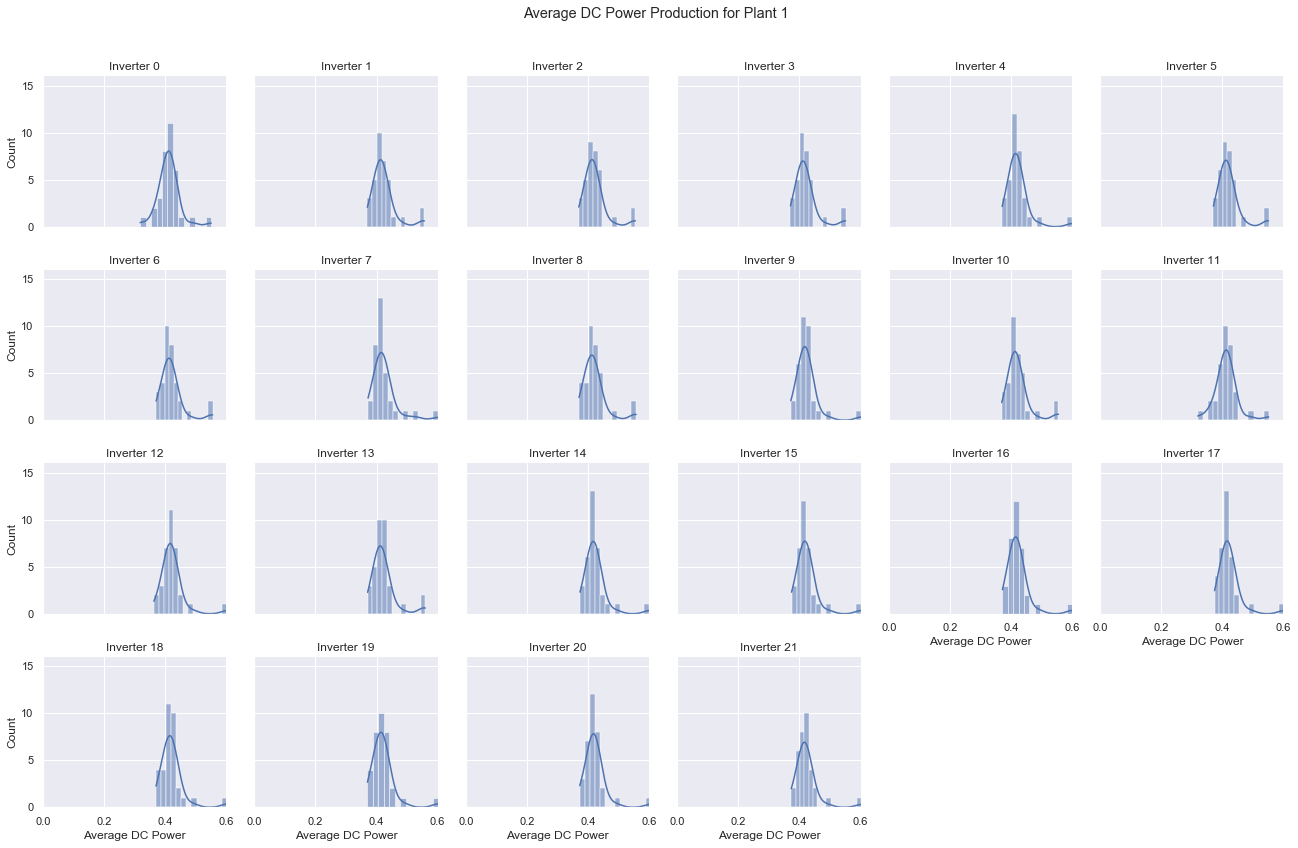

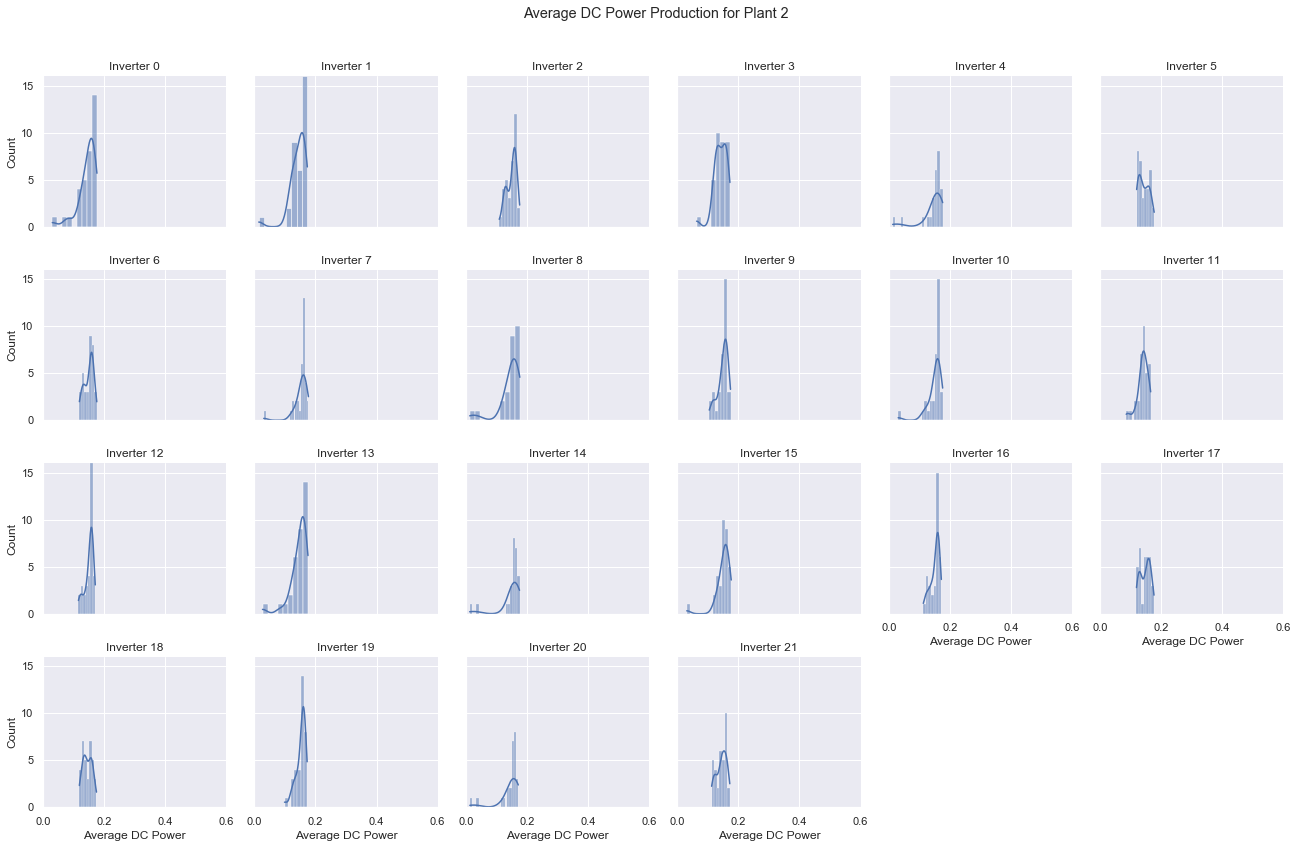

In [97]:
#Using the characters of 1 and 2 so that I can write the variables into filenames later on.
plants = [str(1), str(2)]
for plant in plants:
    #Import and clean generation data
    df = PrepGenerationDataforClassification(('data/Plant_' + plant + '_Generation_Data.csv')).prep_data()
    
    #Plot the average DC production per inverter for each plant. AC production
    #should be comparable
    df_avg = df.groupby(['SOURCE_KEY','date'])[['DC_POWER','AC_POWER']].agg('mean')
    fig, ax = plt.subplots()
    ax = sns.FacetGrid(data = df_avg.reset_index(), col = 'SOURCE_KEY', col_wrap = 6,
                       sharex = True, sharey = True, xlim = (0,0.6), ylim = (0,16))
    ax.map_dataframe(sns.histplot, 'DC_POWER', kde = True, stat = 'count')
    ax.set_axis_labels('Average DC Power', 'Count').set_titles(
        col_template = 'Inverter {col_name}', row_template = '{row_name}')
    plt.subplots_adjust(top = 0.9)
    ax.fig.suptitle('Average DC Power Production for Plant ' + plant)
    
    #Save figure
    filename = 'figures/EDA_Bad_Sensors/Avg_DC_Power_per_Inverter/Plant_'+ plant + '.png'
    ax.savefig(filename)
    plt.close(fig)
    
    #Plot the daily yield per day for each inverter
    #for inverter in df['SOURCE_KEY'].unique():
    #    df_inverter = df[df['SOURCE_KEY'] == inverter]
    #    df_daily_yield = df_inverter.pivot('time', 'date', 'DAILY_YIELD').fillna(method = 'bfill', axis = 1)
    #    multi_plot(df_daily_yield, row = 9, col = 4, inverter = inverter, plant = plant)

So, the two graphs above show the average DC power production for each inverter in each plant. Note that the data was normalized before we graphed it. However, we can clearly see the inverters from Plant 1 have similar outputs and distribution of the data, while Plant 2 inverters are generally lower in their output and their distributions are more erratic.

Below are two examples of the Daily Yields per Day for two chosen inverters. The first is from plant 1 and the other from plant 2. Each line has been commented out to save on space. Since Daily Yield is a cumulative sume, we should expect it to follow a logistic curve, which we can see it does in both graphs. However, we can also see that the inverter from plant 2 has many outlier values, which again denote erratic behavior at the sensor level.

In [103]:
from IPython.display import Image
#Inverter 6 from Plant 1
#Image(filename = 'figures/EDA_Bad_Sensors/Date_vs_Time_per_Inverter/Plant_1/Daily_Yield_Inverter_6.png')

In [104]:
#Inverter 11 from Plant 2
#Image(filename = 'figures/EDA_Bad_Sensors/Date_vs_Time_per_Inverter/Plant_2/Daily_Yield_Inverter_11.png')

### Classifying Panels in Need of Maintainance
Below is my attempt to answer the second question of the project. For this, I'm only considering the Daily Yields for each inverter, and am also combining data from both plants. `eod_describe` holds the descriptive statistics calculated in the `pd.DataFrame.describe()` function.

My first attempt was to run k-means with 2 classes, which ended up only separating the data into Plant 1 and Plant 2. From there, I decided to run affinity propogation, since it determines the number of classes for me, and it split the data into 4 classes. I went back and ran k-means again with 4 classes and got the same result. I've left the code for affinity propogation commented out so you can see how the project progressed, but have chosen to go with k-means.

Displayed below is the explained variance ratios for each component calculated using PCA. As you can see, almost all the variance is explained by one component. The second table shows that component is the `count` of each inverter.

In [100]:
df = pd.read_csv('data/Plant_1_Generation_Data.csv').append(
        pd.read_csv('data/Plant_2_Generation_Data.csv'))
new_sourcekey_num = list(np.arange(0,df['SOURCE_KEY'].nunique()))
old_source_key = list(df['SOURCE_KEY'].unique())
for n in range(len(old_source_key)):
    df = df.replace(old_source_key[n],new_sourcekey_num[n])
del(old_source_key,new_sourcekey_num,n)
normalizer = MinMaxScaler()
df['DAILY_YIELD'] = normalizer.fit_transform(df[['DAILY_YIELD']].values)

eod_describe = df.groupby('SOURCE_KEY')['DAILY_YIELD'].describe()

from sklearn import decomposition
# PCA
pca = decomposition.PCA(n_components=8)
pca.fit_transform(eod_describe)
display(pd.DataFrame((pca.explained_variance_ratio_), columns = ['Explained Varaince'],
                    index = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8']))
display(pd.DataFrame(np.abs(pca.components_),
                     columns=eod_describe.columns,
                     index = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8']).style.background_gradient(cmap = 'Blues'))

#Run affinity propogation, when choosing 4 classes, kmeans produces the same
#result.
#clustering = AffinityPropagation(random_state = 12,
#                                         max_iter = 1000).fit(eod_describe.values)
#eod_describe['class_affinity'] = clustering.labels_

#Run kmeans for 4 classes. Chose 4 classes because affinity propogation determined
#4 classes and it described the data really well.
kmeans = KMeans(n_clusters = 4, random_state = 12)
kmeans.fit(eod_describe.values)
eod_describe['class_kmeans'] = kmeans.labels_

,Explained Varaince
pc1,9.999997e-01
pc2,1.492719e-07
pc3,7.371374e-08
pc4,3.608928e-08
pc5,4.973720e-09
pc6,6.936615e-10
pc7,4.977792e-11
pc8,1.232051e-41


,count,mean,std,min,25%,50%,75%,max
pc1,1.000000,0.000105,0.000020,0.000000,0.000084,0.000162,0.000152,0.000030
pc2,0.000245,0.370569,0.214014,0.000000,0.134263,0.423434,0.761767,0.198154
pc3,0.000088,0.141295,0.311244,0.000000,0.638162,0.527725,0.422712,0.136869
pc4,0.000031,0.008751,0.125193,0.000000,0.136814,0.145952,0.174338,0.955948
pc5,0.000012,0.038904,0.091481,0.000000,0.711624,0.667271,0.194654,0.023844
pc6,0.000002,0.436331,0.782491,0.000000,0.022712,0.031286,0.410485,0.165316
pc7,0.000002,0.806684,0.470096,0.000000,0.221542,0.273273,0.065145,0.016361
pc8,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


Below are the final results from the k-means algorithm. First, a table showing the class that each inverter falls into, along with its `count`; and second, a graph showing how the classes group together by their `count`.

In the table, we can see that Plant 1 was basically its own class, and Plant 2 divided the other three classes based on count. This should be too much of a surprise, since all the inverters in Plant 1 had comparable yields, and the inverters of Plant 2 were all over the place.

What the `count` is representing is the number of valid measurements that were made on the Daily Yield of each inverter. Measurements were taken every 15 minutes. So, the counts which are different enough to qualify as their own class denote inverters which were out of commision for significant periods of time. From that, we can gather that Plant 2 has several inverters in need of maintainance; and even though we've shown Plant 1 has underperforming inverters, all of them are at least working consistently.

,count,class_kmeans
SOURCE_KEY,,
0,3154.000000,0
1,3119.000000,0
2,3118.000000,0
3,3133.000000,0
4,3124.000000,0
5,3133.000000,0
6,3118.000000,0
7,3130.000000,0
8,3123.000000,0


AttributeError: 'AxesSubplot' object has no attribute 'set_titles'

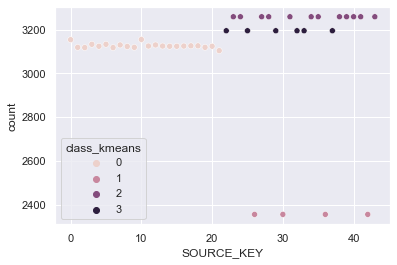

In [101]:
display(eod_describe[['count','class_kmeans']].style.background_gradient(
    cmap = 'Blues').background_gradient(cmap = 'Greens', subset = 'class_kmeans'))
ax = sns.scatterplot(data = eod_describe,
                    x = 'SOURCE_KEY', y = 'count',
                    hue = 'class_kmeans')
ax.set_titles()

## Conclusion
I could do alot more with this data. I haven't even scratched the surface of identifying underperforming equipment. However, the goal of this project was for me to practice with the `scikit-learn` library, and I'm satisfied with what I've done so far. Furthermore, the demands of my current school work require that I take a break from this project. If I find time in the future, I'll come back and continue on from here. Until then, this is the end.